## 1. Import and Install Dependencies

## 1.1 Install dependencies

In [ ]:
!pip install tensorflow tensorflow-gpu tensorflow-io==0.25.0 matplotlib

## 1.2 Load Dependencies

In [1]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio

In [2]:
# Avoid OOM (Out of Memory) errors by settings GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

## 1.3 Define Constants

In [2]:
PARSED_CAPUCHIN_BIRD_DIR = os.path.join('data', 'Parsed_Capuchinbird_Clips')
PARSED_NOT_CAPUCHIN_BIRD_DIR = os.path.join('data', 'Parsed_Not_Capuchinbird_Clips')

## 2. Build Data Loading Function

## 2.1 Define Paths to Files

In [3]:
CAPUCHIN_FILE = os.path.join(PARSED_CAPUCHIN_BIRD_DIR, 'XC3776-3.wav')
NOT_CAPUCHIN_FILE = os.path.join(PARSED_NOT_CAPUCHIN_BIRD_DIR, 'afternoon-birds-song-in-forest-5.wav')

## 2.2 Build Dataloading Function

In [4]:
def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    
    # Decode wav (tensors by channels)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    
    # Goes from 44100hz to 16000hz - amplitude of the audio signal
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    
    return wav

In [5]:
wave = load_wav_16k_mono(CAPUCHIN_FILE)
nwave = load_wav_16k_mono(NOT_CAPUCHIN_FILE)

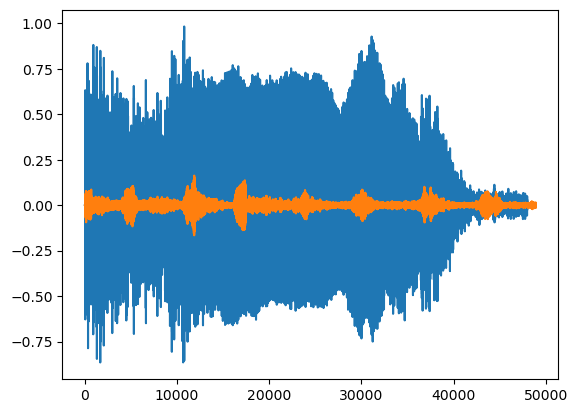

In [6]:
plt.plot(wave)
plt.plot(nwave)
plt.show()

## 3. Create Tensorflow Dataset

## 3.1 Define Paths to Positive and Negative Data

In [7]:
POS = os.path.join('data', 'Parsed_Capuchinbird_Clips')
NEG = os.path.join('data', 'Parsed_Not_Capuchinbird_Clips')

## 3.2 Create Tensorflow Datasets

In [8]:
pos = tf.data.Dataset.list_files(POS+'\*.wav')
neg = tf.data.Dataset.list_files(NEG+'\*.wav')

In [9]:
pos.as_numpy_iterator().next()

b'data\\Parsed_Capuchinbird_Clips\\XC307385-4.wav'

## 3.3 Add labels And Combine Positive and Negative Sample

In [10]:
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
data = positives.concatenate(negatives)

In [11]:
data.shuffle(1000).as_numpy_iterator().next()

(b'data\\Parsed_Not_Capuchinbird_Clips\\cricket-sounds-for-sleep-7.wav', 0.0)

## 4. Determine Average Length of a Capuchin Call

In [12]:
lengths = []
for file in os.listdir(PARSED_CAPUCHIN_BIRD_DIR):
    tensor_wave = load_wav_16k_mono(os.path.join(PARSED_CAPUCHIN_BIRD_DIR, file))
    lengths.append(len(tensor_wave))

In [13]:
mean = tf.math.reduce_mean(lengths)
print(80000 / mean)

tf.Tensor(1.4772139744441983, shape=(), dtype=float64)


In [14]:
min = tf.math.reduce_min(lengths)
print(80000 / min)

tf.Tensor(2.5, shape=(), dtype=float64)


In [15]:
max = tf.math.reduce_max(lengths)
print(80000 / max)

tf.Tensor(1.0, shape=(), dtype=float64)


## 5. Build Preprocessing Function to Convert to Spectrogram

## 5.1 Build Preprocessing Function

In [16]:
def preprocess(file_path, label):
    wav = load_wav_16k_mono(file_path)
    wav = wav[:48000]
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav], 0)
    
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=36)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    
    return spectrogram, label

## 5.2 Test Out the Function and Viz the Spectrogram

In [17]:
filepath, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()

In [18]:
spectrogram, label = preprocess(filepath, label)

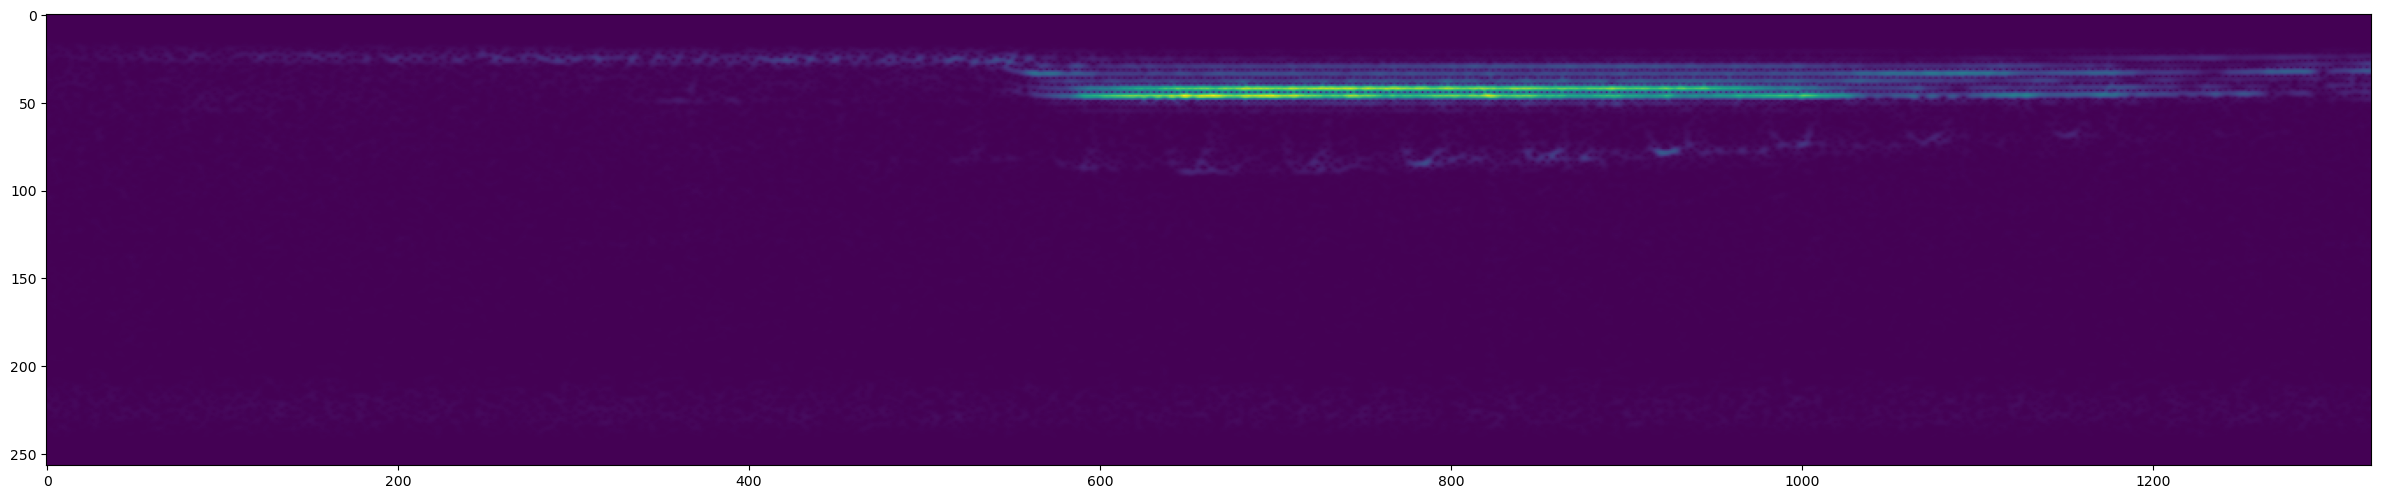

In [19]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

## 6. Create Traning and Testing Partitions

## 6.1 Create a Tensorflow Data Pipeline

In [20]:
preprocessed_data = data.map(preprocess)
cached_data = preprocessed_data.cache()
shuffled_data = cached_data.shuffle(buffer_size=1000)
batched_data = shuffled_data.batch(16)
prefetched_data = batched_data.prefetch(8)

## 6.2 Split into Training and Testing Partitions

In [21]:
len(prefetched_data)*.7

35.699999999999996

In [22]:
train = prefetched_data.skip(36)
test = prefetched_data.skip(36).take(15)

## 6.3 Test One Batch

In [23]:
samples, labels = train.as_numpy_iterator().next()

In [24]:
samples.shape

(16, 1325, 257, 1)

In [25]:
labels

array([1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
      dtype=float32)

## 7. Build Deep Learning Model

## 7.1 Load Tensorflow Dependencies

In [26]:
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Conv2D, Dense, Flatten

In [27]:
model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(1325, 257, 1)))
model.add(Conv2D(16, (3,3) , activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

ResourceExhaustedError: failed to allocate memory [Op:AddV2]